In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pizza-not-pizza/pizza_not_pizza/food101_subset.py
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2374305.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2415437.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1123352.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2294128.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/215349.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/938244.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/444123.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/884964.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2394770.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/901984.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/117282.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1227349.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1743531.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/21

Pizza Sınıflandırma Projesi - CNN ile Derin Öğrenme
📝 Proje Amacı
Bu projede, Convolutional Neural Network (CNN) mimarisi kullanarak görüntülerin pizza olup olmadığını sınıflandıran bir derin öğrenme modeli geliştireceğiz. Proje şu konuları kapsamaktadır:

Görüntü işleme ve veri ön işleme
CNN model tasarımı
Veri artırma (Data Augmentation)
Model performans analizi
Hiperparametre optimizasyonu

In [6]:
# Temel kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2

# Makine öğrenmesi kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow ve Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Uyarıları gizle
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 6]

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



2️Veri Setinin Keşfi ve Analizi
⚠️ ÖNEMLİ: Kaggle'da Veri Setini Doğru Bağlama

In [7]:
# Kaggle'da veri setinin doğru yolu
data_dir = "/kaggle/input/pizza-not-pizza/pizza_not_pizza"

# Alt klasörlerin yolları
pizza_dir = os.path.join(data_dir, "pizza")
not_pizza_dir = os.path.join(data_dir, "not_pizza")
# Klasörlerin varlığını kontrol et
print("Veri seti klasörleri:")
print(f"Pizza klasörü var mı: {os.path.exists(pizza_dir)}")
print(f"Not Pizza klasörü var mı: {os.path.exists(not_pizza_dir)}")

Veri seti klasörleri:
Pizza klasörü var mı: True
Not Pizza klasörü var mı: True


Veri Seti Hakkında İstatistiksel Bilgiler
Veri setimiz iki sınıftan oluşmaktadır:

Pizza: Çeşitli pizza görüntüleri
Not Pizza: Pizza olmayan yiyecek görüntüleri

Bu ikili sınıflandırma problemi, binary classification yaklaşımı ile çözülecektir.
Veri Görselleştirmesi

In [8]:
# Dosya sayılarının hesaplanması
pizza_files = os.listdir(pizza_dir)
not_pizza_files = os.listdir(not_pizza_dir)

pizza_count = len(pizza_files)
not_pizza_count = len(not_pizza_files)
total_images = pizza_count + not_pizza_count

print("=== VERİ SETİ İSTATİSTİKLERİ ===")
print(f"🍕 Pizza görüntü sayısı: {pizza_count}")
print(f"🚫 Pizza olmayan görüntü sayısı: {not_pizza_count}")
print(f"📊 Toplam görüntü sayısı: {total_images}")
print(f"⚖️ Sınıf dengesi: {pizza_count/total_images:.1%} Pizza, {not_pizza_count/total_images:.1%} Not Pizza")

=== VERİ SETİ İSTATİSTİKLERİ ===
🍕 Pizza görüntü sayısı: 983
🚫 Pizza olmayan görüntü sayısı: 983
📊 Toplam görüntü sayısı: 1966
⚖️ Sınıf dengesi: 50.0% Pizza, 50.0% Not Pizza



 Veri Görselleştirmesi
Sınıf Dağılımının Görselleştirilmesi

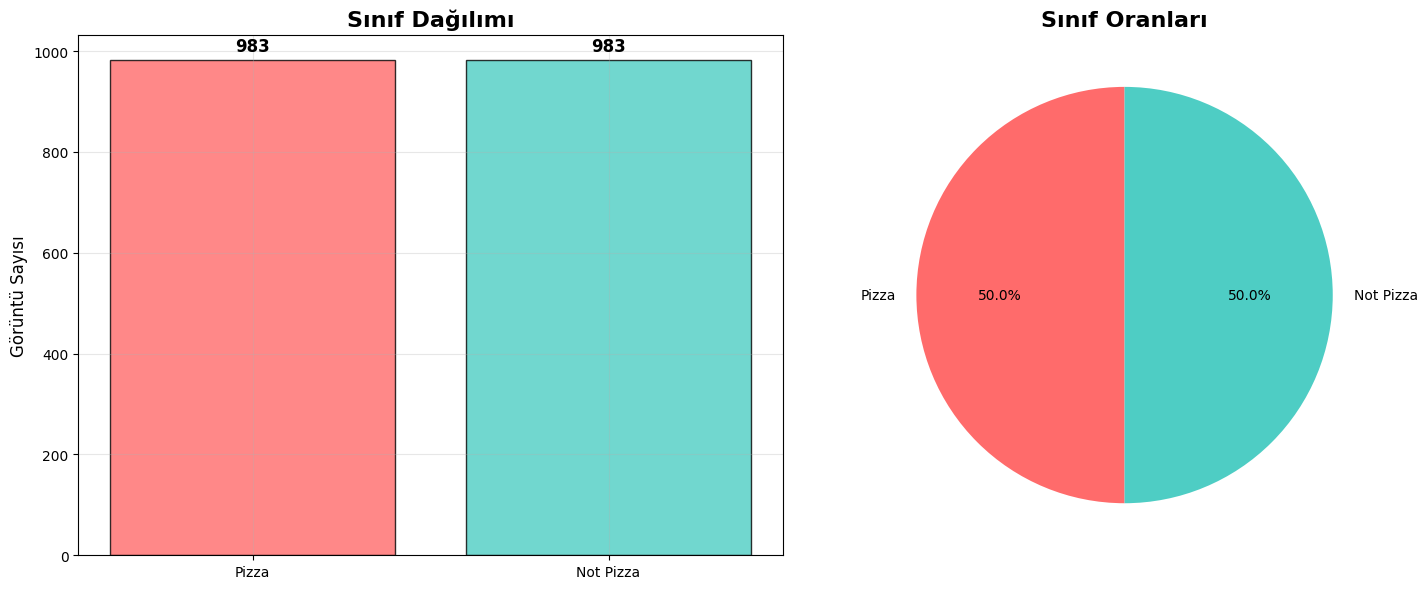

In [9]:
# Sınıf dağılımı grafiği
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
classes = ['Pizza', 'Not Pizza']
counts = [pizza_count, not_pizza_count]
colors = ['#FF6B6B', '#4ECDC4']

bars = ax1.bar(classes, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Sınıf Dağılımı', fontsize=16, fontweight='bold')
ax1.set_ylabel('Görüntü Sayısı', fontsize=12)
ax1.grid(True, alpha=0.3)

# Bar üzerine değer yazma
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Pie chart
wedges, texts, autotexts = ax2.pie(counts, labels=classes, autopct='%1.1f%%', 
                                   colors=colors, startangle=90)
ax2.set_title('Sınıf Oranları', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

Örnek Görüntülerin Gösterilmesi

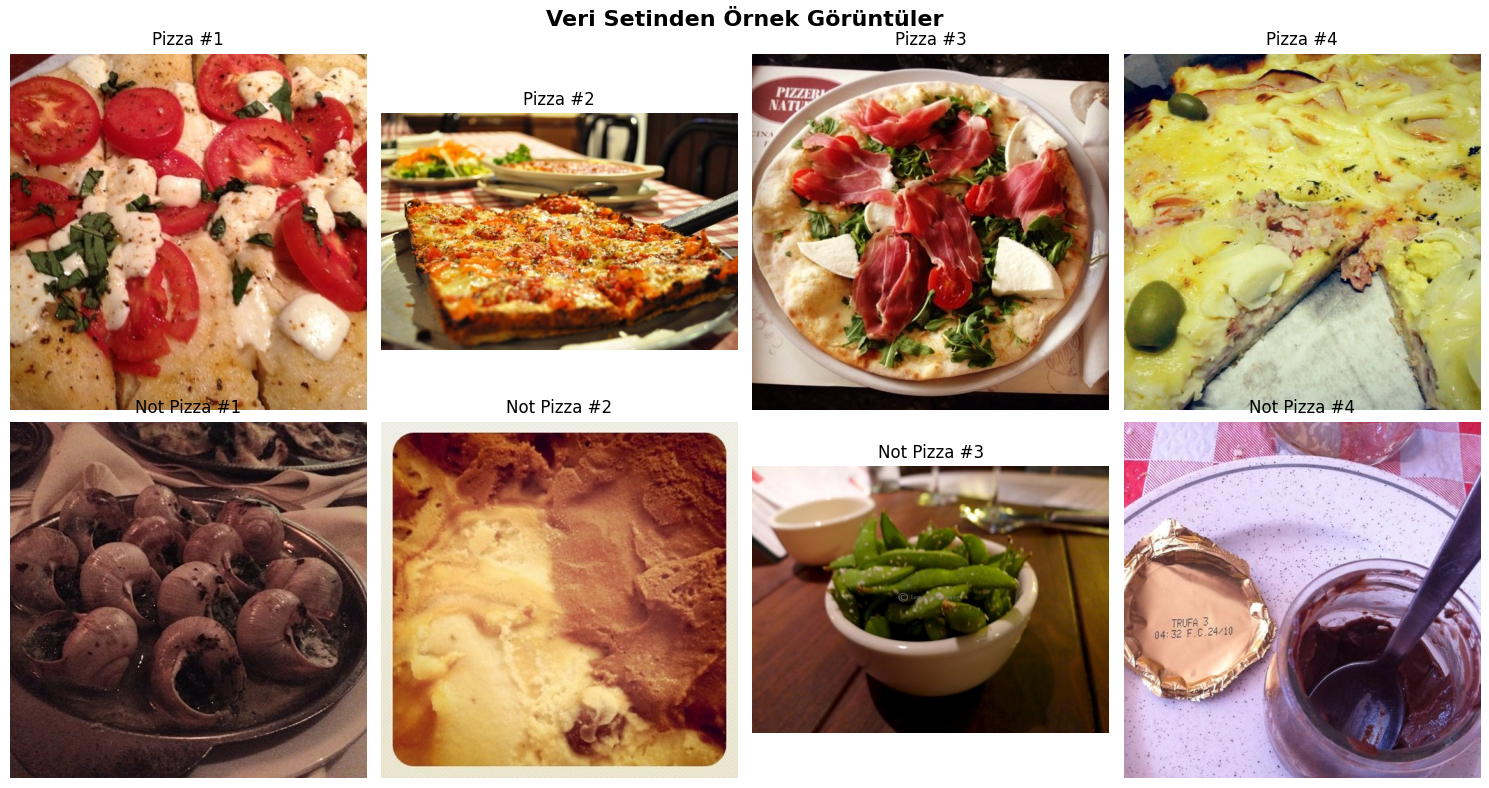

In [10]:
def show_sample_images(pizza_dir, not_pizza_dir, samples_per_class=4):
    """Her sınıftan örnek görüntüleri gösterir"""
    
    fig, axes = plt.subplots(2, samples_per_class, figsize=(15, 8))
    
    # Pizza örnekleri
    pizza_samples = np.random.choice(pizza_files, samples_per_class, replace=False)
    for i, img_name in enumerate(pizza_samples):
        img_path = os.path.join(pizza_dir, img_name)
        img = Image.open(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f'Pizza #{i+1}', fontsize=12)
        axes[0, i].axis('off')
    
    # Not Pizza örnekleri
    not_pizza_samples = np.random.choice(not_pizza_files, samples_per_class, replace=False)
    for i, img_name in enumerate(not_pizza_samples):
        img_path = os.path.join(not_pizza_dir, img_name)
        img = Image.open(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f'Not Pizza #{i+1}', fontsize=12)
        axes[1, i].axis('off')
    
    plt.suptitle('Veri Setinden Örnek Görüntüler', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Örnek görüntüleri göster
show_sample_images(pizza_dir, not_pizza_dir)

Görüntü Boyutlarının Analizi

In [11]:
def analyze_image_dimensions(directory, class_name, sample_size=100):
    """Görüntü boyutlarını analiz eder"""
    files = os.listdir(directory)
    sample_files = np.random.choice(files, min(sample_size, len(files)), replace=False)
    
    widths, heights = [], []
    
    for img_file in sample_files:
        try:
            img_path = os.path.join(directory, img_file)
            img = Image.open(img_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
        except Exception as e:
            continue
    
    print(f"=== {class_name.upper()} SINIFI BOYUT ANALİZİ ===")
    print(f"Genişlik - Min: {min(widths)}, Max: {max(widths)}, Ortalama: {np.mean(widths):.1f}")
    print(f"Yükseklik - Min: {min(heights)}, Max: {max(heights)}, Ortalama: {np.mean(heights):.1f}")
    
    return widths, heights

# Her iki sınıf için boyut analizi
pizza_widths, pizza_heights = analyze_image_dimensions(pizza_dir, "Pizza")
not_pizza_widths, not_pizza_heights = analyze_image_dimensions(not_pizza_dir, "Not Pizza")

=== PIZZA SINIFI BOYUT ANALİZİ ===
Genişlik - Min: 382, Max: 512, Ortalama: 492.2
Yükseklik - Min: 288, Max: 512, Ortalama: 481.4
=== NOT PIZZA SINIFI BOYUT ANALİZİ ===
Genişlik - Min: 324, Max: 512, Ortalama: 499.8
Yükseklik - Min: 288, Max: 512, Ortalama: 476.3


Veri Yükleme ve Ön İşleme Fonksiyonları

In [12]:
# Görüntü boyutu ve parametreler
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
CHANNELS = 3

def preprocess_image(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    """Görüntüyü ön işlemeden geçirir"""
    try:
        # Görüntüyü yükle
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=CHANNELS)
        
        # Boyutu ayarla
        image = tf.image.resize(image, target_size)
        image = tf.image.convert_image_dtype(image, tf.float32)
        
        # Normalizasyon [0,1] aralığına
        image = image / 255.0
        
        return image
    except:
        return None

def load_and_preprocess_data():
    """Veri setini yükler ve ön işlemden geçirir"""
    
    image_paths = []
    labels = []
    
    # Pizza görüntüleri (label = 1)
    for img_name in pizza_files:
        image_paths.append(os.path.join(pizza_dir, img_name))
        labels.append(1)
    
    # Not Pizza görüntüleri (label = 0)
    for img_name in not_pizza_files:
        image_paths.append(os.path.join(not_pizza_dir, img_name))
        labels.append(0)
    
    print(f"Toplam yüklenen görüntü: {len(image_paths)}")
    
    return np.array(image_paths), np.array(labels)

# Veriyi yükle
image_paths, labels = load_and_preprocess_data()

Toplam yüklenen görüntü: 1966


 Train-Validation-Test Setlerine Ayırma

In [13]:
# İlk olarak train ve temp (validation + test) olarak ayır
X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(
    image_paths, labels, 
    test_size=0.3,  # %30'u validation + test için
    random_state=42,
    stratify=labels  # Sınıf oranlarını koru
)

# Temp'i validation ve test olarak ayır
X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_temp_paths, y_temp,
    test_size=0.5,  # Temp'in yarısı test, yarısı validation
    random_state=42,
    stratify=y_temp
)

print("=== VERİ SETİ BÖLÜNME İSTATİSTİKLERİ ===")
print(f"🏋️ Training set: {len(X_train_paths)} görüntü ({len(X_train_paths)/len(image_paths):.1%})")
print(f"✅ Validation set: {len(X_val_paths)} görüntü ({len(X_val_paths)/len(image_paths):.1%})")
print(f"🧪 Test set: {len(X_test_paths)} görüntü ({len(X_test_paths)/len(image_paths):.1%})")

# Sınıf dağılımlarını kontrol et
print(f"\nTrain set sınıf dağılımı: Pizza {np.sum(y_train)}, Not Pizza {len(y_train)-np.sum(y_train)}")
print(f"Validation set sınıf dağılımı: Pizza {np.sum(y_val)}, Not Pizza {len(y_val)-np.sum(y_val)}")
print(f"Test set sınıf dağılımı: Pizza {np.sum(y_test)}, Not Pizza {len(y_test)-np.sum(y_test)}")

=== VERİ SETİ BÖLÜNME İSTATİSTİKLERİ ===
🏋️ Training set: 1376 görüntü (70.0%)
✅ Validation set: 295 görüntü (15.0%)
🧪 Test set: 295 görüntü (15.0%)

Train set sınıf dağılımı: Pizza 688, Not Pizza 688
Validation set sınıf dağılımı: Pizza 148, Not Pizza 147
Test set sınıf dağılımı: Pizza 147, Not Pizza 148


Data Augmentation (Veri Artırma)
ImageDataGenerator ile Veri Artırma

In [14]:
# Veri artırma parametreleri
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalizasyon
    rotation_range=20,            # 20 derece döndürme
    width_shift_range=0.2,        # Genişlik kaydırma
    height_shift_range=0.2,       # Yükseklik kaydırma
    shear_range=0.2,              # Kesme dönüşümü
    zoom_range=0.2,               # Zoom
    horizontal_flip=True,         # Yatay çevirme
    fill_mode='nearest',          # Boşlukları doldurma
    brightness_range=[0.8, 1.2]  # Parlaklık değişimi
)

# Validation ve test için sadece normalizasyon
val_test_datagen = ImageDataGenerator(rescale=1./255)

def create_data_generators():
    """Data generator'ları oluşturur"""
    
    # Geçici klasörler oluştur (Kaggle'da çalışması için)
    temp_train_dir = "/tmp/train"
    temp_val_dir = "/tmp/val"
    temp_test_dir = "/tmp/test"
    
    # Klasörleri oluştur
    for directory in [temp_train_dir, temp_val_dir, temp_test_dir]:
        os.makedirs(os.path.join(directory, "pizza"), exist_ok=True)
        os.makedirs(os.path.join(directory, "not_pizza"), exist_ok=True)
    
    # Dosyaları kopyala (symbolic link kullanarak)
    import shutil
    
    def copy_files(paths, labels, target_dir):
        for path, label in zip(paths, labels):
            class_name = "pizza" if label == 1 else "not_pizza"
            filename = os.path.basename(path)
            target_path = os.path.join(target_dir, class_name, filename)
            shutil.copy2(path, target_path)
    
    print("Geçici klasörler oluşturuluyor...")
    copy_files(X_train_paths, y_train, temp_train_dir)
    copy_files(X_val_paths, y_val, temp_val_dir)
    copy_files(X_test_paths, y_test, temp_test_dir)
    
    # Data generator'ları oluştur
    train_generator = train_datagen.flow_from_directory(
        temp_train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True
    )
    
    validation_generator = val_test_datagen.flow_from_directory(
        temp_val_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        temp_test_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

# Data generator'ları oluştur
train_gen, val_gen, test_gen = create_data_generators()

print(f"✅ Training generator: {train_gen.samples} samples")
print(f"✅ Validation generator: {val_gen.samples} samples") 
print(f"✅ Test generator: {test_gen.samples} samples")

Geçici klasörler oluşturuluyor...
Found 1376 images belonging to 2 classes.
Found 295 images belonging to 2 classes.
Found 295 images belonging to 2 classes.
✅ Training generator: 1376 samples
✅ Validation generator: 295 samples
✅ Test generator: 295 samples


Veri Artırma Örneklerinin Görselleştirilmesi 

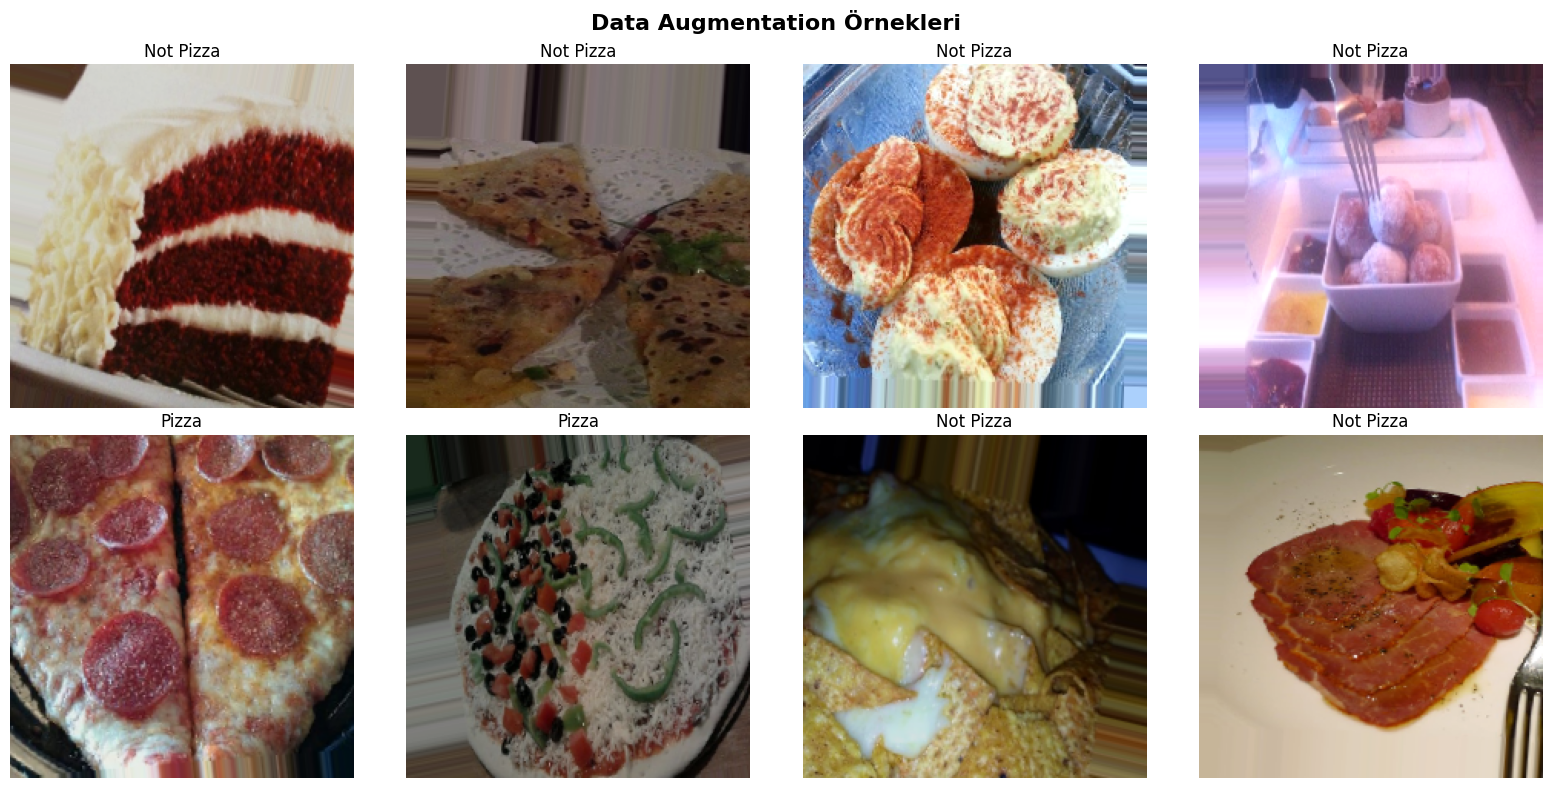

In [15]:
def visualize_augmentation():
    """Veri artırma örneklerini gösterir"""
    
    # Bir batch al
    batch_x, batch_y = next(train_gen)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    for i in range(8):
        row = i // 4
        col = i % 4
        
        axes[row, col].imshow(batch_x[i])
        label = "Pizza" if batch_y[i] > 0.5 else "Not Pizza"
        axes[row, col].set_title(f'{label}', fontsize=12)
        axes[row, col].axis('off')
    
    plt.suptitle('Data Augmentation Örnekleri', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Veri artırma örneklerini göster
visualize_augmentation()

Model Mimarisinin Oluşturulması

In [16]:
def create_cnn_model():
    """CNN modeli oluşturur"""
    
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
        
        # İlk Konvolüsyonel Blok
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # İkinci Konvolüsyonel Blok
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Üçüncü Konvolüsyonel Blok
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Dördüncü Konvolüsyonel Blok
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Global Average Pooling (Fully Connected'a alternatif)
        layers.GlobalAveragePooling2D(),
        
        # Dense Layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output layer (Binary classification için sigmoid)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Model oluştur
model = create_cnn_model()

# Model özetini göster
print("=== MODEL MİMARİSİ ===")
model.summary()

# Model parametrelerini hesapla
total_params = model.count_params()
print(f"\n📊 Toplam parametre sayısı: {total_params:,}")

I0000 00:00:1758872147.668190      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758872147.668920      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


=== MODEL MİMARİSİ ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 850,337 (3.24 MB)

 Trainable params: 847,841 (3.23 MB)

 Non-trainable params: 2,496 (9.75 KB)


📊 Toplam parametre sayısı: 850,337


Model Derleme

In [17]:
# Model derleme
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("✅ Model başarıyla derlendi!")

✅ Model başarıyla derlendi!


 Callback'lerin Tanımlanması

In [18]:
# Callback'leri tanımla
callbacks = [
    # Erken durdurma
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Learning rate azaltma
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    ),
    
    # En iyi modeli kaydetme
    ModelCheckpoint(
        'best_pizza_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

print("✅ Callback'ler tanımlandı!")

✅ Callback'ler tanımlandı!


Model Eğitimi

In [ ]:
# Eğitim parametreleri
EPOCHS = 50

print("🚀 Model eğitimi başlıyor...")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")

# Model eğitimi
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("✅ Model eğitimi tamamlandı!")

🚀 Model eğitimi başlıyor...
Epochs: 50
Batch size: 32
Epoch 1/50


I0000 00:00:1758872159.557935     131 service.cc:148] XLA service 0x79f82810df30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758872159.559691     131 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758872159.559721     131 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758872160.556206     131 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/43 ━━━━━━━━━━━━━━━━━━━━ 19:43 28s/step - accuracy: 0.5312 - loss: 0.9901 - precision: 0.5625 - recall: 0.5294

I0000 00:00:1758872179.038753     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.5431 - loss: 1.0325 - precision: 0.5355 - recall: 0.5700
Epoch 1: val_accuracy improved from -inf to 0.48958, saving model to best_pizza_model.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 51s 549ms/step - accuracy: 0.5442 - loss: 1.0303 - precision: 0.5367 - recall: 0.5705 - val_accuracy: 0.4896 - val_loss: 0.7782 - val_precision: 0.4896 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.6314 - loss: 0.8182 - precision: 0.6554 - recall: 0.6314
Epoch 2: val_accuracy did not improve from 0.48958
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 443ms/step - accuracy: 0.6316 - loss: 0.8174 - precision: 0.6550 - recall: 0.6317 - val_accuracy: 0.4896 - val_loss: 0.6870 - val_precision: 0.4896 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6627 - loss: 0.7080 - precision: 0.6483 - recall: 0.6700
Epoch 3: val_accuracy improved from 0.48958 to 0.50347

Model Performans Analizi
Eğitim Geçmişinin Görselleştirilmesi

In [ ]:
def plot_training_history(history):
    """Eğitim geçmişini görselleştirir"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2)
    axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2)
    axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Eğitim geçmişini görselleştir
plot_training_history(history)

Test Setinde Model Değerlendirmesi

In [ ]:
# Test setinde değerlendirme
print("🧪 Test setinde model değerlendirmesi...")

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    test_gen,
    steps=test_gen.samples // BATCH_SIZE,
    verbose=1
)

# F1 Score hesaplama
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("\n=== TEST SETİ SONUÇLARI ===")
print(f"🎯 Test Accuracy: {test_accuracy:.4f}")
print(f"📏 Test Precision: {test_precision:.4f}")
print(f"🔍 Test Recall: {test_recall:.4f}")
print(f"⚡ Test F1-Score: {test_f1:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")

Confusion Matrix

In [ ]:
# Confusion matrix için tahminler
print("Tahminler hesaplanıyor...")
test_gen.reset()
predictions = model.predict(test_gen, steps=test_gen.samples // BATCH_SIZE, verbose=1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Gerçek etiketleri al
true_labels = test_gen.classes[:len(predicted_classes)]

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Pizza', 'Pizza'],
            yticklabels=['Not Pizza', 'Pizza'])
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print("\n=== CLASSIFICATION REPORT ===")
target_names = ['Not Pizza', 'Pizza']
print(classification_report(true_labels, predicted_classes, target_names=target_names))

Model Görselleştirme ve Analiz
Modelin Hangi Bölgelerden Etkilendiğini Gösterme (Grad-CAM)

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Grad-CAM heatmap oluşturur"""
    
    # Gradient modelini oluştur
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # Son konvolüsyon katmanının çıktısına göre gradyanları hesapla
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Son konvolüsyon katmanı çıktısını gradyanlarla çarp
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # 0-1 arasında normalize et
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

def display_gradcam(image_path, heatmap, alpha=0.4):
    """Grad-CAM görselleştirmesi"""
    # Orijinal görüntüyü yükle
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    # Heatmap'i görüntü boyutuna getir
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Heatmap'i renkli hale getir
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Görüntüyü heatmap ile birleştir
    superimposed_img = heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)